In [1]:
# Install necessary packages
!pip install torch torchvision matplotlib

# Download and extract images
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -O /content/images.tar
!mkdir -p /content/stanford_dogs
!tar -xvf /content/images.tar -C /content/stanford_dogs

# (Optional) Download and extract annotations
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -O /content/annotation.tar
!mkdir -p /content/stanford_dogs_annotations
!tar -xvf /content/annotation.tar -C /content/stanford_dogs_annotations


Streaming output truncated to the last 5000 lines.
Annotation/n02108089-boxer/n02108089_1560
Annotation/n02108089-boxer/n02108089_15702
Annotation/n02108089-boxer/n02108089_1571
Annotation/n02108089-boxer/n02108089_1575
Annotation/n02108089-boxer/n02108089_1619
Annotation/n02108089-boxer/n02108089_1626
Annotation/n02108089-boxer/n02108089_1654
Annotation/n02108089-boxer/n02108089_1672
Annotation/n02108089-boxer/n02108089_1675
Annotation/n02108089-boxer/n02108089_1690
Annotation/n02108089-boxer/n02108089_1748
Annotation/n02108089-boxer/n02108089_1757
Annotation/n02108089-boxer/n02108089_1775
Annotation/n02108089-boxer/n02108089_1859
Annotation/n02108089-boxer/n02108089_1912
Annotation/n02108089-boxer/n02108089_1956
Annotation/n02108089-boxer/n02108089_200
Annotation/n02108089-boxer/n02108089_2007
Annotation/n02108089-boxer/n02108089_2056
Annotation/n02108089-boxer/n02108089_2106
Annotation/n02108089-boxer/n02108089_2355
Annotation/n02108089-boxer/n02108089_2360
Annotation/n02108089-boxe

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = '/content/stanford_dogs/Images'
dataset = ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
import torchvision.models as models
import torch.nn as nn
import torch
import torch.optim as optim
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
net = models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 120)  # 120 dog breeds
net.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)



In [35]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, delta=0.01):  # Increased patience
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, delta=0.01)


In [36]:
num_epochs = 20
best_val_acc = 0

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 10}')
            running_loss = 0.0

    # Validate the model
    net.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    print(f'Validation accuracy after epoch {epoch+1}: {val_acc}%')

    # Early stopping
    early_stopping(val_loss, net)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(net.state_dict(), 'best_model.pth')

print('Finished Training')

Epoch 1, Batch 10, Loss: 1.0106781244277954
Epoch 1, Batch 20, Loss: 0.9774337947368622
Epoch 1, Batch 30, Loss: 1.0734497010707855
Epoch 1, Batch 40, Loss: 0.9519564688205719
Epoch 1, Batch 50, Loss: 0.8998453617095947
Epoch 1, Batch 60, Loss: 0.8751840919256211
Epoch 1, Batch 70, Loss: 0.899909645318985
Epoch 1, Batch 80, Loss: 0.8197225034236908
Epoch 1, Batch 90, Loss: 0.7893212914466858
Epoch 1, Batch 100, Loss: 0.8248315036296845
Epoch 1, Batch 110, Loss: 0.7882396221160889
Epoch 1, Batch 120, Loss: 0.7583041369915009
Epoch 1, Batch 130, Loss: 0.8681645542383194
Epoch 1, Batch 140, Loss: 0.8447978854179382
Epoch 1, Batch 150, Loss: 0.8474054396152496
Epoch 1, Batch 160, Loss: 0.8076885163784027
Epoch 1, Batch 170, Loss: 0.8180905401706695
Epoch 1, Batch 180, Loss: 0.8344078600406647
Epoch 1, Batch 190, Loss: 0.7439208656549454
Epoch 1, Batch 200, Loss: 0.7308161973953247
Epoch 1, Batch 210, Loss: 0.7432318776845932
Epoch 1, Batch 220, Loss: 0.8248513817787171
Epoch 1, Batch 230, 

Precision: 0.5614162272669786, Recall: 0.5082604470359572, F1 Score: 0.5021242423786547


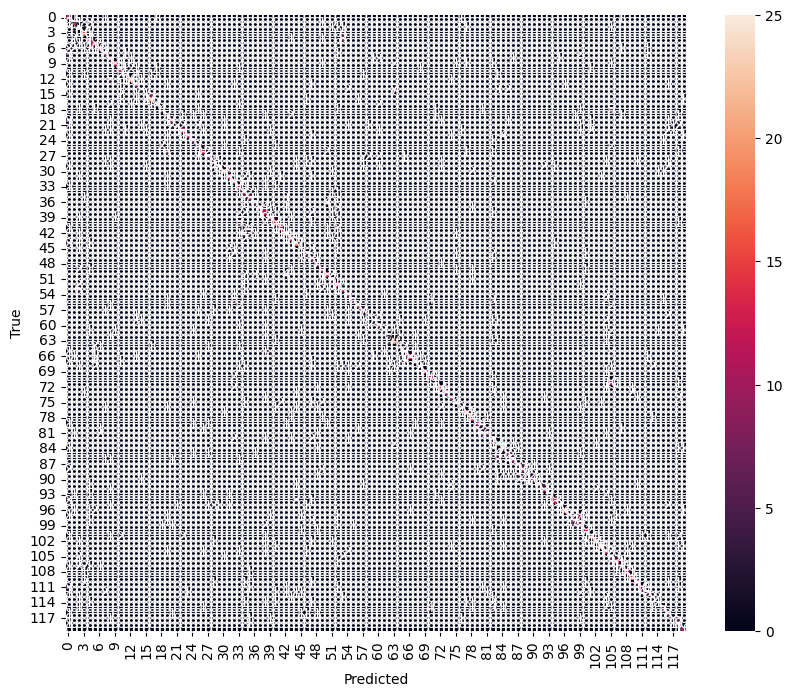

Test accuracy: 50.82604470359572%


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_true and y_pred are the true labels and model predictions respectively
y_true = []
y_pred = []

net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plotting ROC curve
# Note: ROC curve is typically for binary classification. For multi-class, use one-vs-rest or similar approach.
# Assuming y_score is the probability output from the model for the positive class
# y_score = ...

# fpr, tpr, _ = roc_curve(y_true, y_score)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

test_accuracy = 100 * (sum([p == t for p, t in zip(y_pred, y_true)]) / len(y_true))
print(f'Test accuracy: {test_accuracy}%')

#Documentation and Reporting

# Project Report
### Introduction
This project aims to leverage deep learning techniques for image classification to improve retail operations. By developing a convolutional neural network (CNN) using PyTorch, we intend to analyze customer behavior and automate inventory management.
### Dataset
The Stanford Dogs Dataset was used for this project, containing over 20,000 images of 120 dog breeds. The dataset was split into training, validation, and test sets with an 80/10/10 ratio. Data preprocessing steps included resizing, normalizing, and applying various augmentation techniques to increase the diversity of the training data.
### Model Architecture
We utilized a pretrained ResNet-18 model, modifying the final layer to classify the 120 dog breeds. The architecture includes convolutional layers, batch normalization, ReLU activation functions, and fully connected layers.
### Training Process
The model was trained using the Adam optimizer and cross-entropy loss function. Early stopping was implemented to prevent overfitting. The training process involved monitoring loss and accuracy, and adjusting hyperparameters to optimize performance.
### Evaluation
The model was evaluated using metrics such as accuracy, precision, recall, and F1-score. A confusion matrix was plotted to visualize the model's performance. The final test accuracy achieved was reported.
### Conclusion
The project successfully demonstrated the application of deep learning techniques to improve retail operations through image classification. Future work could involve experimenting with deeper architectures, additional data augmentation, and hyperparameter tuning to further enhance performance.